In [1]:

import numpy as np
import matplotlib.pyplot as plt
import time, copy


from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn import tree


from matplotlib.colors import ListedColormap
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])



# from sklearn create data for classification

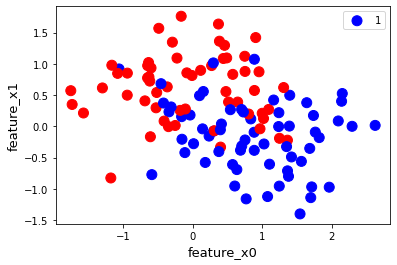

number of examples = m = 120
number of features = n = 2


In [2]:
X, Y = make_moons(n_samples=200, noise=0.4, random_state=0)
#X, Y = make_circles(n_samples=200, noise=0.1, random_state=0)
#X, Y = make_blobs(n_samples=200, centers=2, n_features=2, random_state=0)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
TrainSet = np.append(X_train, Y_train.reshape(-1,1), axis=1)
TestSet = np.append(X_test, Y_test.reshape(-1,1), axis=1)



#--------------------------------------------------------------------------------------

XX = X_train
YY = Y_train


sct = plt.scatter(XX[:,0], XX[:,1], s=100, c=YY, marker='o',cmap=cm_bright)  
plt.legend(labels=YY)
plt.xlabel("feature_x0", fontsize=13)
plt.ylabel("feature_x1", fontsize=13)
plt.show()


m, n  = XX.shape 
print(f'number of examples = m = {m}')
print(f'number of features = n = {n}')




# function for optimal cut value corresponding to minimum gini 

Gini(Y_train) = 0.49875


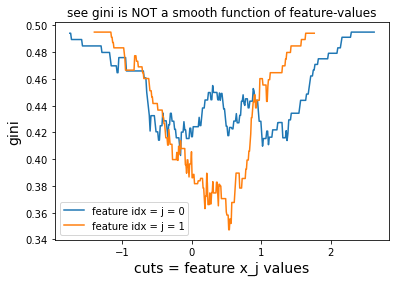

opt_cuts_0,1 = [-0.161  0.532]
min_ginis_0,1 = [0.403 0.347] 

selected_j = 1, cut = 0.532, Gini = 0.347



In [3]:

def Gini(Y):           
    mean_1 = np.mean(Y)                         # mean_0 = prob of getting 0 = 1 - mean_1
    return 1 - (mean_1)**2 - (1- mean_1)**2     # = gini to measure purity of a node



''' 
for jth feature, this function will give number of cuts and corresponding ginis 
by changing num_cuts, one can change the performance (accuracy given in the end)
'''
def cuts_ginis(dataset, j): 
    X, Y = dataset[:,:-1], dataset[:,-1]
    
    cs_gs = []
    Xj = X[:,j]
    Xj_min = np.min(Xj)
    Xj_max = np.max(Xj)
    num_cuts = 3*X.shape[0]  # number of Xj values = a multiple of the number of example
    step_size = (Xj_max - Xj_min)/num_cuts
    
    cuts = np.arange(Xj_min, Xj_max+step_size, step_size)
    
    for cut in cuts:
        idx_1 = np.where(Xj <= cut)[0]
        idx_2 = np.where(Xj > cut)[0]
        
        Y_cut_1 = Y[idx_1]
        Y_cut_2 = Y[idx_2]
        
        l1 = Y_cut_1.shape[0]
        l2 = Y_cut_2.shape[0]
        if l1*l2 ==0:                                                            # If any of Y_cut is empty
            Gini_Y_cut = Gini(Y)
        else:
            Gini_Y_cut = (l1/(l1+l2))*Gini(Y_cut_1) + (l2/(l1+l2))*Gini(Y_cut_2) # weighted average
            
        cs_gs.append([cut, Gini_Y_cut])
    
    return np.array(cs_gs)


def OptCut_minGini(dataset):
    n = dataset.shape[1]-1                            # n = number of features
    
    opt_cuts_min_ginis = []
    for j in range(n):
        cs_gs = cuts_ginis(dataset, j)
        min_gini = np.min(cs_gs[:,1])                 # min_gini = maximum clearity or purity)
        idx = np.where(cs_gs[:,1]==min_gini)[0][0]
        opt_cut = cs_gs[idx, 0]                       # cut-value corresponding to min_gini
        
        opt_cuts_min_ginis.append([opt_cut, min_gini])
        
    return np.array(opt_cuts_min_ginis)




def selected_j_cut_Gini(opt_cuts_min_ginis):
    min_Ginis = opt_cuts_min_ginis[:, 1]
    min_min_Gini = min_Ginis.min()
    j = np.where(min_Ginis==min_min_Gini)[0][0]
    selected_j, cut, gini = j, opt_cuts_min_ginis[j,0], opt_cuts_min_ginis[j,1]
    return selected_j, cut, gini



def bifurcated_datasets(dataset, selected_j, cut):
    X, Y = dataset[:,:-1], dataset[:,-1]

    ids_left = np.where(X[:,selected_j] < cut)[0]
    all_ids = np.arange(X.shape[0]) 
    ids_right = np.delete(all_ids, ids_left)
 
    dataset_left = dataset[ids_left]
    dataset_right = dataset[ids_right]
    
    return dataset_left, dataset_right




def bifurcation(dataset):
    opt_cuts_min_ginis = OptCut_minGini(dataset)
    selected_j, cut, gini = selected_j_cut_Gini(opt_cuts_min_ginis)
    dataset_left, dataset_right = bifurcated_datasets(dataset, selected_j, cut)    
    return selected_j, cut, gini, dataset_left, dataset_right



def decision_tree(dataset, depth = 0):
    
    X, Y = dataset[:,:-1], dataset[:,-1]
    num_samples = dataset.shape[0]
    Gini_Y = Gini(Y)
    num_ones = int(np.sum(Y))
 
    if Gini_Y > 0 and num_samples > min_samples_split and depth < max_depth: # if the conditions hold, split and call it a node
        selected_j, cut, gini, dataset_left, dataset_right = bifurcation(dataset)
        if dataset_left.shape[0] >0 and dataset_right.shape[0]>0: # if both datasets are nonempty
            left_branch = decision_tree(dataset_left, depth+1)
            right_branch = decision_tree(dataset_right, depth+1)
            return ['node', selected_j, cut, Gini_Y, num_samples, [Y.shape[0]-num_ones, num_ones], left_branch, right_branch]
        else:
            return ['leaf', Gini_Y, num_samples, [Y.shape[0]-num_ones, num_ones]] 
            
    elif Gini_Y==0 or num_samples == min_samples_split or depth == max_depth:
        return ['leaf', Gini_Y, num_samples, [Y.shape[0]-num_ones, num_ones]]  



#============================================================================================

dataset = TrainSet 


cs_gs_0 = cuts_ginis(dataset, 0)
cs_gs_1 = cuts_ginis(dataset, 1)


print("Gini(Y_train) =", Gini(Y_train))

fontsize=14
plt.plot(cs_gs_0[:,0], cs_gs_0[:,1], label='feature idx = j = 0')
plt.plot(cs_gs_1[:,0], cs_gs_1[:,1], label='feature idx = j = 1')
plt.title("see gini is NOT a smooth function of feature-values")
plt.xlabel("cuts = feature x_j values", fontsize=fontsize)
plt.ylabel("gini", fontsize=fontsize)
plt.legend()
plt.show()


#--------------------------------------------------------------------------------------


opt_cuts_min_ginis = OptCut_minGini(dataset)
print(f"opt_cuts_0,1 = {np.round(opt_cuts_min_ginis[:,0], 3)}")
print(f"min_ginis_0,1 = {np.round(opt_cuts_min_ginis[:,1],3)} \n")


selected_j, cut, gini = selected_j_cut_Gini(opt_cuts_min_ginis)
print(f"selected_j = {selected_j}, cut = {round(cut,3)}, Gini = {round(gini,3)}\n")

#bifurcated_datasets(dataset, selected_j, cut)


# our Decision Tree Classifier

In [4]:

dataset = TrainSet 
X, Y = dataset[:,:-1], dataset[:,-1]

min_samples_split = 2 # must be >=2
max_depth = 3         # must be >=1


our_decision_tree = decision_tree(dataset)
our_decision_tree


['node',
 1,
 0.5315296754738377,
 0.49875,
 120,
 [57, 63],
 ['node',
  0,
  -0.17436230555176335,
  0.4066453284560281,
  81,
  [23, 58],
  ['node',
   0,
   -0.5952941158315272,
   0.39111111111111097,
   15,
   [11, 4],
   ['leaf', 0.0, 6, [6, 0]],
   ['leaf', 0.49382716049382713, 9, [5, 4]]],
  ['node',
   1,
   -0.3500893495520563,
   0.2975206611570247,
   66,
   [12, 54],
   ['leaf', 0.0, 21, [0, 21]],
   ['leaf', 0.3911111111111112, 45, [12, 33]]]],
 ['node',
  1,
  1.0730572703326404,
  0.22353714661406965,
  39,
  [34, 5],
  ['node',
   1,
   0.9780297351779622,
   0.29336734693877564,
   28,
   [23, 5],
   ['leaf', 0.21120000000000005, 25, [22, 3]],
   ['leaf', 0.4444444444444444, 3, [1, 2]]],
  ['leaf', 0.0, 11, [11, 0]]]]

In [5]:

def predict(tree, x):
    if tree[0]=='leaf':                          # here, tree[-1]  = [num_zeros, num_ones]
        return np.argmax(tree[-1])               # = 1 if num_zeros < num_ones, 0 otherwise, 
    else:                              # it is a node
        selected_feature = tree[1]
        threshold_value = tree[2]
        if x[selected_feature] < threshold_value:
            tree = tree[-2]
            #print("left_subtree--->", tree)
            return predict(tree, x) 
        else:
            tree = tree[-1]
            #print("right_subtree--->", tree)
            return predict(tree, x)
    


def accuracy(dataset, our_decision_tree):
    X, Y = dataset[:,:-1], dataset[:,-1]
    
    Y_pred =[]
    for x in X:
        y_pred = predict(our_decision_tree, x)
        Y_pred.append(y_pred)

    nonmatch = np.abs(Y-Y_pred)    # = 0 of matches, 1 otherwise
    accu = 1-np.mean(nonmatch)
    return  accu



#============================================================================================

    
print(f'our Train accuracy  = {round(accuracy(TrainSet, our_decision_tree),3)}')
print(f'our Test accuracy  = {round(accuracy(TestSet, our_decision_tree),3)}\n')

print(our_decision_tree)


our Train accuracy  = 0.833
our Test accuracy  = 0.725

['node', 1, 0.5315296754738377, 0.49875, 120, [57, 63], ['node', 0, -0.17436230555176335, 0.4066453284560281, 81, [23, 58], ['node', 0, -0.5952941158315272, 0.39111111111111097, 15, [11, 4], ['leaf', 0.0, 6, [6, 0]], ['leaf', 0.49382716049382713, 9, [5, 4]]], ['node', 1, -0.3500893495520563, 0.2975206611570247, 66, [12, 54], ['leaf', 0.0, 21, [0, 21]], ['leaf', 0.3911111111111112, 45, [12, 33]]]], ['node', 1, 1.0730572703326404, 0.22353714661406965, 39, [34, 5], ['node', 1, 0.9780297351779622, 0.29336734693877564, 28, [23, 5], ['leaf', 0.21120000000000005, 25, [22, 3]], ['leaf', 0.4444444444444444, 3, [1, 2]]], ['leaf', 0.0, 11, [11, 0]]]]


$ $




# sklearn Decision Tree Classifier

Train Accuracy with sklearn = 0.833
Test Accuracy with sklearn = 0.738


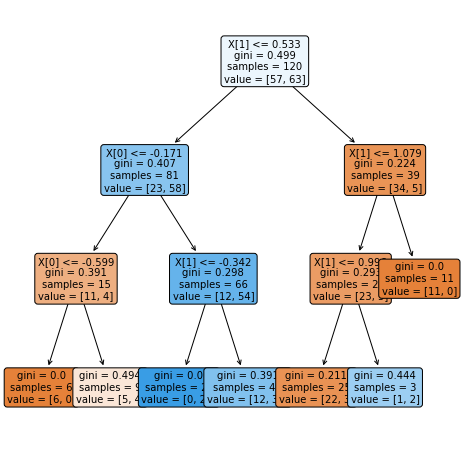

In [6]:
clf = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
clf_fit_DT = clf.fit(X, Y)

siz = 8
fig = plt.figure(figsize=(siz, siz))
_ = tree.plot_tree(clf_fit_DT, rounded=True, filled=True, fontsize=10)

print(f'Train Accuracy with sklearn = {round(clf.score(TrainSet[:, :-1],TrainSet[:,-1]), 3)}')
print(f'Test Accuracy with sklearn = {round(clf.score(TestSet[:, :-1],TestSet[:,-1]), 3)}')
    

# Decision function contour plot

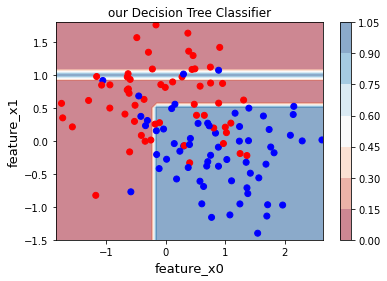

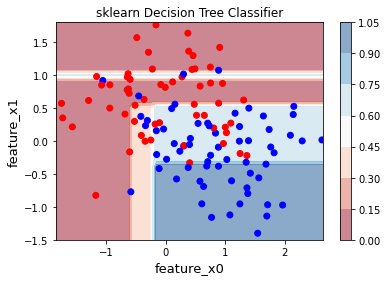

In [9]:

delta = 0.1 
h = 0.1                                                          # h = step size in the mesh
x0_min, x0_max = X[:, 0].min() - delta, X[:, 0].max() + delta
x1_min, x1_max = X[:, 1].min() - delta, X[:, 1].max() + delta

x0, x1 = np.meshgrid(np.arange(x0_min, x0_max, h), np.arange(x1_min, x1_max, h))
xs = np.c_[x0.ravel(), x1.ravel()]


#-----------------------------------------------------------------------------


Z = []
for x in xs:
    Z.append(predict(our_decision_tree, x))
Z = np.array(Z).reshape(x0.shape)


#plt.rcParams["figure.figsize"] = (9,9)
cntr1 = plt.contourf(x0, x1, Z, cmap=cm, alpha=0.5)            # s=100 = size, alpha = Opacity
plt.colorbar(cntr1)
plt.scatter(X[:,0], X[:,1],  c=Y, marker='o', cmap=cm_bright)  
plt.title('our Decision Tree Classifier')
plt.xlabel("feature_x0", fontsize=13)
plt.ylabel("feature_x1", fontsize=13)
plt.show()



#-----------------------------------------------------------------------------


Z = clf.predict_proba(xs)[:, 1]
Z = Z.reshape(x0.shape)

cntr1 = plt.contourf(x0, x1, Z, cmap=cm, alpha=0.5)
plt.colorbar(cntr1)
plt.scatter(X[:,0], X[:,1],  c=Y, marker='o', cmap=cm_bright)  
plt.title('sklearn Decision Tree Classifier')
plt.xlabel("feature_x0", fontsize=13)
plt.ylabel("feature_x1", fontsize=13)
plt.show()
